<a href="https://colab.research.google.com/github/behaapyy/bioinformatics_with_python/blob/main/CookBook_CH3(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###  **게놈 주석 살펴보기**

- 게놈 데이터에서 유전자, 엑손, 단백질 암호화 서열 등의 특성 정보를 얻기 위해서는 GFF 파일을 사용 (Generic Feature Format)
  - 엑손: DNA 서열에서 단백질이나 RNA를 코딩하는 암호화 서열
  - 인트론 : 엑손 사이사이에 존재하는 비암호화 서열
- 이 장에서는 Anophleles gambiae 게놈 데이터를 GFF 파일로 파싱하고 분석하는 방법을 배움
  - GFF란? 게놈의 일반적인 주석 형식
  - SQLite 데이터베이스란? 데이터베이스 관리 시스템이지만, 서버가 아니라 응용 프로그램에 넣어 사용하는 비교적 가벼운 데이터베이스





In [ ]:
!rm -f PlasmoDB-9.3_Pfalciparum3D7_Genome.fasta 2>/dev/null
!wget http://plasmodb.org/common/downloads/release-9.3/Pfalciparum3D7/fasta/data/PlasmoDB-9.3_Pfalciparum3D7_Genome.fasta

--2022-07-16 15:38:21--  http://plasmodb.org/common/downloads/release-9.3/Pfalciparum3D7/fasta/data/PlasmoDB-9.3_Pfalciparum3D7_Genome.fasta
Resolving plasmodb.org (plasmodb.org)... 128.192.21.13
Connecting to plasmodb.org (plasmodb.org)|128.192.21.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://plasmodb.org/common/downloads/release-9.3/Pfalciparum3D7/fasta/data/PlasmoDB-9.3_Pfalciparum3D7_Genome.fasta [following]
--2022-07-16 15:38:21--  https://plasmodb.org/common/downloads/release-9.3/Pfalciparum3D7/fasta/data/PlasmoDB-9.3_Pfalciparum3D7_Genome.fasta
Connecting to plasmodb.org (plasmodb.org)|128.192.21.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23723399 (23M) [application/x-fasta]
Saving to: ‘PlasmoDB-9.3_Pfalciparum3D7_Genome.fasta’

PlasmoDB-9.3_Pfalci 100%[===================>]  22.62M   114MB/s    in 0.2s    

2022-07-16 15:38:21 (114 MB/s) - ‘PlasmoDB-9.3_Pfalciparum3D7_Genome.fasta’ saved [2

In [ ]:
!rm -rf ag.db gambiae.fa.gz 2>/dev/null
!wget ftp://ftp.vectorbase.org/public_data/organism_data/agambiae/Genome/agambiae.CHROMOSOMES-PEST.AgamP3.fa.gz -O gambiae.fa.gz

--2022-07-16 15:49:48--  ftp://ftp.vectorbase.org/public_data/organism_data/agambiae/Genome/agambiae.CHROMOSOMES-PEST.AgamP3.fa.gz
           => ‘gambiae.fa.gz’
Resolving ftp.vectorbase.org (ftp.vectorbase.org)... 129.74.255.228
Connecting to ftp.vectorbase.org (ftp.vectorbase.org)|129.74.255.228|:21... failed: Connection timed out.
Retrying.

--2022-07-16 15:52:00--  ftp://ftp.vectorbase.org/public_data/organism_data/agambiae/Genome/agambiae.CHROMOSOMES-PEST.AgamP3.fa.gz
  (try: 2) => ‘gambiae.fa.gz’
Connecting to ftp.vectorbase.org (ftp.vectorbase.org)|129.74.255.228|:21... failed: Connection timed out.
Retrying.

--2022-07-16 15:54:12--  ftp://ftp.vectorbase.org/public_data/organism_data/agambiae/Genome/agambiae.CHROMOSOMES-PEST.AgamP3.fa.gz
  (try: 3) => ‘gambiae.fa.gz’
Connecting to ftp.vectorbase.org (ftp.vectorbase.org)|129.74.255.228|:21... failed: Connection timed out.
Retrying.

--2022-07-16 15:56:25--  ftp://ftp.vectorbase.org/public_data/organism_data/agambiae/Genome/agambi

In [ ]:
!pip install gffutils
from collections import defaultdict

import gffutils
import sqlite3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.2 MB/s 
     |████████████████████████████████| 102 kB 45.6 MB/s 
     |████████████████████████████████| 130 kB 52.7 MB/s 
  Created wheel for gffutils: filename=gffutils-0.11.0-py3-none-any.whl size=1617539 sha256=c5a20c18c8b815256af69fedba613e6b457f1cdb7a448545d4456cb5c4c378fa
  Stored in directory: /root/.cache/pip/wheels/ed/42/98/e79a4e6a3a69299717be407322cf2b771c825f918954f6419f
  Created wheel for pyfaidx: filename=pyfaidx-0.7.0-py3-none-any.whl size=27697 sha256=f4083ccf1f2ee4288642a8e3c739f91e1b3bce0fbc87afad42ca2e2b6727836f
  Stored in directory: /root/.cache/pip/wheels/df/6b/ce/46374a70af569061fa10a6c16525b0d8efe2d9a4069f8a144a
Successfully built gffutils pyfaidx


아래부터는 gff 라이브러리를 이용해 파일에 필요한 데이터베이스를 만드는 과정

*   gffutils 라이브러리는 게놈의 주석 정보를 효율적으로 저장하는 SQLite 데이터베이스를 만든다




In [ ]:
!rm -f ag.db

In [ ]:
try:
    db = gffutils.create_db('https://vectorbase.org/common/downloads/Pre-VEuPathDB%20VectorBase%20files/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.gff3.gz', 'ag.db')
except sqlite3.OperationalError:
    db = gffutils.FeatureDB('ag.db')

HTTPError: ignored

아래는 사용 가능한 특성의 유형들과 개수를 출력하는 코드

In [ ]:
print(list(db.featuretypes()))
for feat_type in db.featuretypes():
    print(feat_type, db.count_features_of_type(feat_type))

콘티그의 모든 특성 유형을 확인한다, 이 출력으로 모든 상염색체와 성염색체, 미토콘드리아, 알려지지 않은 염색체의 주석 정보를 확인함
- 시퀀스 자른게 리드, 리드 모은게 콘티그

In [ ]:
for contig in db.features_of_type('contig'):
    print(contig)

염색체별로 유전자의 개수, 유전자별 전사 산물의 수, 엑손의 숫자와 같은 유용한 정보들을 추출
- 모든 콘티그 특성들을 순회하면서 전사 산물이 존재하면 전사당 엑손의 개수, 전사 산물이 존재하지 않는다면 엑손의 개수만 헤아림 

In [ ]:
num_mRNAs = defaultdict(int)
num_exons = defaultdict(int)
max_exons = 0
max_span = 0
for contig in db.features_of_type('contig'):
    cnt = 0
    for gene in db.region((contig.seqid, contig.start, contig.end), featuretype='gene'):
        cnt += 1
        span = abs(gene.start - gene.end) # strand
        if span > max_span:
            max_span = span
            max_span_gene = gene
        my_mRNAs = list(db.children(gene, featuretype='mRNA'))
        num_mRNAs[len(my_mRNAs)] += 1
        if len(my_mRNAs) == 0:
            exon_check = [gene]
        else:
            exon_check = my_mRNAs
        for check in exon_check:
            my_exons = list(db.children(check, featuretype='exon'))
            num_exons[len(my_exons)] += 1
            if len(my_exons) > max_exons:
                max_exons = len(my_exons)
                max_exons_gene = gene
    print('contig %s, number of genes %d' % (contig.seqid, cnt))
print('Max number of exons: %s (%d)' % (max_exons_gene.id, max_exons))
print('Max span: %s (%d)' % (max_span_gene.id, max_span))
print(num_mRNAs)
print(num_exons)

* GFF 파일 형식 
  - gmod.org/wiki/GFF3
  - standard file format for storing genomic features in a text file
* BED 파일 
  - genome.ucsc.edu/FAQ/FAQformat.html#format1
  - provides a flexible way to define the data lines that are displayed in an annotation track

### **게놈 주석으로 원하는 유전자 추출하기**
주석 정보를 통해 참조 게놈의 FASTA 파일에서 살충제 저항성에 관한 VGSC 유전자를 추출해보자

In [ ]:
import gzip
from Bio import Alphabet, Seq, SeqIO

VectorBase : 질병 매개체 데이터베이스, 원하는 유전자의 식별자는 사용자가 직접 검색해서 찾아야 함

In [ ]:
gene_id = 'AGAP004707'
gene = db[gene_id]
print(gene)
print(gene.seqid, gene.strand)

NameError: ignored

2L 염색체의 전체 서열을 메모리에 불러오기

In [ ]:
recs = SeqIO.parse(gzip.open('gambiae.fa.gz', 'rt', encoding='utf-8'), 'fasta')
for rec in recs:
    print(rec.description)
    if rec.description.split(':')[2] == gene.seqid:
        my_seq = rec.seq
        break
print(my_seq.alphabet)

단백질 암호화 서열 (Coding sequence)의 목록을 만들어주는 함수 
- DNA 서열을 단백질 서열로 번역하는 과정, 전사 산물 중 mRNA 만 선택한다 
  - 전사 산물로 나온 RNA 종류에는 3가지 있음 (mRNA, rRNA, tRNA) 

In [ ]:
def get_sequence(chrom_seq, CDSs, strand):
    seq = Seq.Seq('', alphabet=Alphabet.IUPAC.unambiguous_dna)
    for CDS in CDSs:
        #FRAME???
        my_cds = Seq.Seq(str(chrom_seq[CDS.start - 1: CDS.end]), alphabet=Alphabet.IUPAC.unambiguous_dna)
        seq += my_cds
    return seq if strand == '+' else seq.reverse_complement()

In [ ]:
mRNAs = db.children(gene, featuretype='mRNA')
for mRNA in mRNAs:
    print(mRNA.id)
    if mRNA.id.endswith('RA'):
        break


mRNA에 상응하는 Coding sequence 얻은 뒤에 단백질 서열로 번역

In [ ]:
CDSs = db.children(mRNA, featuretype='CDS', order_by='start')
gene_seq = get_sequence(my_seq, CDSs, gene.strand)

print(len(gene_seq), gene_seq)
prot = gene_seq.translate()
print(len(prot), prot)

(-) 가닥 DNA에 대한 예시로 유전자 근처에 존재하는 유전자를 처리 - mRNA 가닥은 DNA 에서 전사된 것, (+) strand
- 전사식별자를 하드코딩했으나 실제 분석할 때는 이렇게 사용하면 안됨!

In [ ]:
reverse_transcript_id = 'AGAP004708-RA
reverse_CDSs = db.children(reverse_transcript_id, featuretype='CDS', order_by='start')
reverse_seq = get_sequence(my_seq, reverse_CDSs, '-')

print(len(reverse_seq), reverse_seq)
reverse_prot = reverse_seq.translate()
print(len(reverse_prot), reverse_prot)


CDS와 엑손의 차이

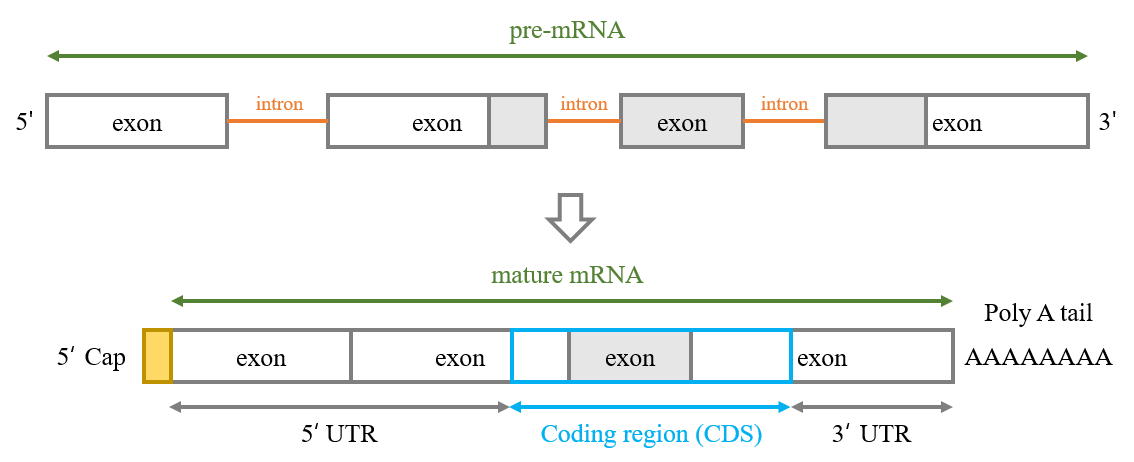